# Fase 1: Clasificación del movimiento

**Descripción**\
En esta fase, se desarrollarán y evaluarán modelos de Machine Learning con el objetivo de predecir el gesto que está realizando un paciente.
* Creación de Modelos: implementación y entrenamiento de modelos de clasificación para reconocer el tipo de gesto realizado por el paciente.
* Evaluación de Modelos: evaluación del rendimiento de los modelos entrenados utilizando métricas específicas y disintas gráficas.

**Entrada**
* ``medidasPerRepetition.csv``: fichero en formato csv con cálculos estadísticos sobre los ángulos por repetición de cada sujeto. Es el fichero de salida de *leer_dataset.ipynb*.

**Índice**
1. [Preprocesado](#1-preprocesado)
    - [Codificar variables](#11-codificar-variables)
    - [Dividir el dataset](#12-dividir-el-dataset)
2. [Modelos de ML](#2-modelos-de-ml)
    - [Funciones creadas](#21-funciones-creadas)
    - [Modelos con parámetros por defecto](#22-modelos-con-parámetros-por-defecto)
    - [Hiperparametrización](#23-hipermetrización)
    - [Selección de variables](#24-selección-de-variables)
3. [Evaluación de los modelos](#3-evaluación-de-los-modelos)

******

In [1]:
# ---------- importar librerías---------
# Manipular los datos
import pandas as pd
import numpy as np

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

# scikit-learn (ML en python)
## Procesar el dataset
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import LeaveOneGroupOut
## Modelos ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
## Evaluación de los modelos
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, LearningCurveDisplay
## Hiperparametrizacion
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

## Seleccion de variables
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_selection import RFECV # recursive

# Para ignorar los FutureWarning
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
#---------Importar los datos-----------
# Dataframe medidas calculadas por repetición
df = pd.read_csv('../Resultados/medidasPerRepetition.csv', dtype=object) # salida de leer_dataset.ipynb
df.head() # visualizacion de la cabecera

,SubjectID,GestureLabel,RepetitionNumber,CorrectLabel,Position,Duration,ElbowAngleRight_standardDeviation,ElbowAngleLeft_standardDeviation,ShoulderAngleLeft_standardDeviation,ShoulderAngleRight_standardDeviation,...,WristAngleLeft_Kurtosis,RightArmAngle_Kurtosis,LeftArmAngle_Kurtosis,KneeAngleLeft_Kurtosis,WristAngleRight_Kurtosis,KneeAngleRight_Kurtosis,HipAngleRight_Kurtosis,ArmsTogetherAngle_Kurtosis,HipAngleLeft_Kurtosis,AnkleAngleLeft_Kurtosis
0,101,0,1,1,stand,59,39.820354449729585,0.46999747533942593,0.1605055535262188,2.6396543627886215,...,-1.1548519667455222,0.5520411109908268,0.5374402120462101,1.7710014047083118,0.19853266525825441,-0.6282124890039413,-0.9240468871850966,-0.6043028159859238,0.06225622298840339,-0.04284048578579691
1,101,0,2,1,stand,44,37.94439662868307,0.12137980698470821,0.14048642518660973,2.8353774342490965,...,-0.7701703570143632,0.9827020482811872,0.7268055218978855,-0.3639623655630544,1.0481449056142007,-0.5811360931938645,-0.19860783889835965,0.8934212147732565,-1.0781673012402413,-0.15399547466992702
2,101,0,3,1,stand,53,49.054705841375245,0.20895858712540405,0.37872588781987016,2.282540537914713,...,-0.5806536048592652,-0.24963124981935225,0.1405061114156383,0.19518406030957225,-0.3931234568509234,-0.16602188800603868,-1.007601590228747,-0.4138693928861996,-0.9412656492315614,-0.5791289028671893
3,101,0,4,1,stand,57,48.91636872995308,0.30666183448668577,0.3656303661100792,2.2101717684598863,...,-0.13640312363512264,-0.6102973032983008,1.0602340465863236,-0.6882051769936814,-0.6109341257432597,-1.4671142980921754,-1.4875437672995169,-1.2588076707533085,-1.4405855673525283,0.8551681433459608
4,101,0,5,1,stand,60,47.890589574807436,0.1510695564513937,0.4475739701634633,2.3245667618638177,...,-0.42688443195923,-0.7871223719820266,-1.527706279445947,1.9573808887146877,-1.1701446029912246,-0.17062220467378442,-1.4273439546363045,-0.33874666284848587,-1.0916461712416958,1.165992239625116


****

## 1. Preprocesado

### 1.1 Codificar variables

In [3]:
# ------Preparar el dataset-------
encoder = OrdinalEncoder(categories=[list(set(df["Position"].values))])
encoder.fit(df[["Position"]])
df["Position"] = encoder.transform(df[["Position"]])

# pasar variable obj to numeric
df = df.apply(pd.to_numeric, errors='ignore')

### 1.2 Dividir el dataset

In [4]:
# ---- Dividir en test y train -----------
test_df = df.loc[(df.SubjectID==101) | (df.SubjectID==105) | (df.SubjectID==201) | (df.SubjectID==202) | (df.SubjectID==301) | (df.SubjectID==302)]
train_df = df.loc[(df.SubjectID!=101) & (df.SubjectID!=105) & (df.SubjectID!=201) & (df.SubjectID!=202) & (df.SubjectID!=301) & (df.SubjectID!=302)] 

# ------- Dividir en target y variables ---------
train_X = train_df.drop(['GestureLabel'], axis=1)
train_y=pd.DataFrame(train_df['GestureLabel']) 
test_X= test_df.drop(['GestureLabel'], axis=1) 
test_y =pd.DataFrame(test_df['GestureLabel'])

# Convertimos los df de target (y) a 1-d
train_y = train_y.values.ravel()
test_y = test_y.values.ravel()

*****

## 2. Modelos de ML

### 2.1 Funciones creadas

In [5]:
# Dataframe para guardar los resultados
test_result = pd.DataFrame({'Clasificadores': ['K-Neighbors',
                                            'Decision tree',
                                            'Naive Bayes',
                                            'Suport Vector Machine',
                                            'Random Forest']})

#-------Funcion para evaluar los modelos-----------
def test_models(modelos: list, tX: pd.DataFrame, ty: np.ndarray, df: pd.DataFrame, column_name: str):
   """
   Evalúa una lista de modelos usando la métrica F1-score ponderada ('weighted') y\\
   guarda los resultados en un DataFrame.

   Parámetros
   ----------
   modelos : list
      Lista de modelos a evaluar. Cada modelo debe implementar el método `.predict`.
   tX : pd.DataFrame
      Conjunto de datos de prueba con las características.
   ty : np.ndarray
      Array con los valores reales de la salida del conjunto de prueba.
   df : pd.DataFrame
      DataFrame donde se almacenarán los F1-scores resultantes.
   column_name : str
      Nombre de la columna en `df` donde se guardarán los resultados de la evaluación.
   """
   new_evaluation = []
   for modelo in modelos:
      prediction = modelo.predict(tX) #  predicciones en los datos de prueba
      report = classification_report(ty, prediction, zero_division=0) # informe de evaluación
      score = f1_score(test_y, prediction, average='weighted') 
      new_evaluation.append(score)
      print(f"\nModelo: {modelo.__class__.__name__}") 
      print(report) 
   df.loc[:, column_name] = new_evaluation

#-----------Función matriz de confusión-----
def plot_confusion_matrix(modelo, tX: pd.DataFrame, ty: np.ndarray):
    """
    Grafica la matriz de confusión para un modelo de clasificación dado.

    Parámetros
    ----------
    modelo : sklearn.base.BaseEstimator
        El modelo de clasificación entrenado. Debe implementar el método `.predict`.
    tX : pd.DataFrame
        Conjunto de datos de prueba con las características.
    ty : np.ndarray
        Array con los valores reales de la salida del conjunto de prueb
    """
    prediction = modelo.predict(tX)
    cm = confusion_matrix(ty, prediction)
    ax = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
    ax.set_title('Matriz de confusión ' + modelo.__class__.__name__)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

### 2.2 Modelos con parámetros por defecto

In [6]:
#--------intanciar modelos de ML----------
knn = KNeighborsClassifier() # K-Neighbors classifier
dtree = DecisionTreeClassifier() # Decision tree
nb = GaussianNB() # Naive Bayes
svm = SVC() # Suport Vector Machine
rf = RandomForestClassifier()  # Random Forest

#--------entrenamiento de los modelos----------
models = [knn, dtree, nb, svm, rf]

for modelo in models:
    modelo.fit(train_X, train_y)

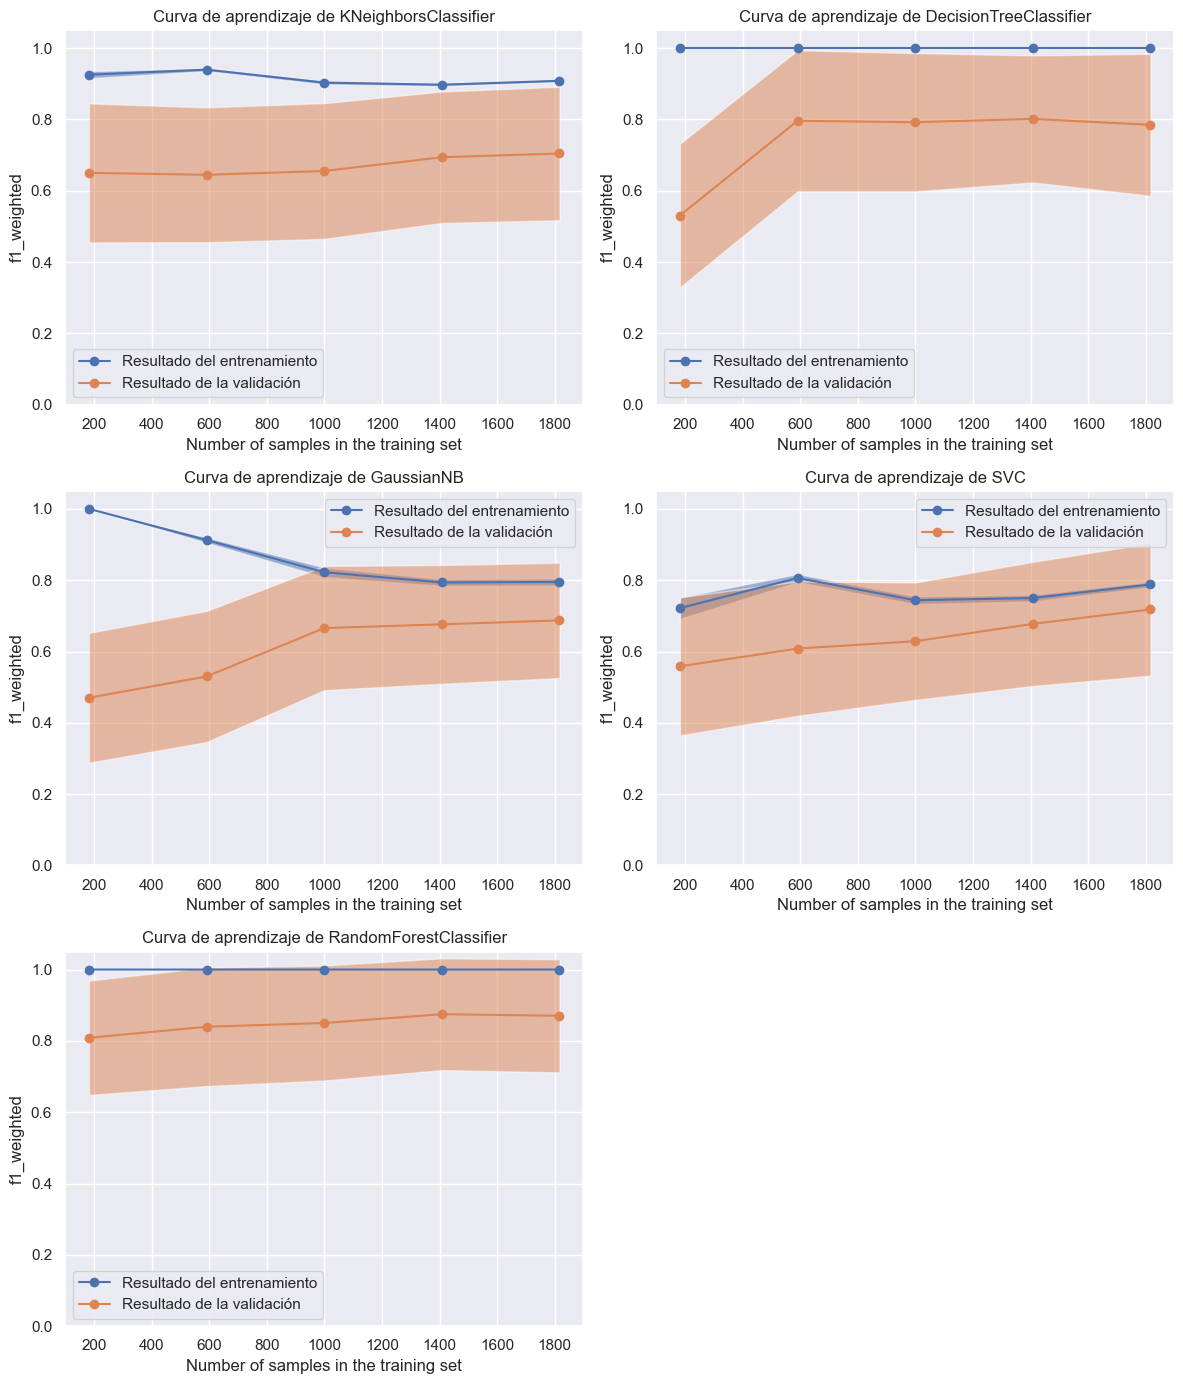

In [7]:
#---------- Curvas de apendizaje -------------
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 14))

common_params = {
    "X": train_X,
    "y": train_y,
    "groups": train_X['SubjectID'],
    "cv": LeaveOneGroupOut(),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f1_weighted",
}
for idx, estimator in enumerate(models):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
    handles, label = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ["Resultado del entrenamiento",
                            "Resultado de la validación"])
    ax.set_title(f"Curva de aprendizaje de {estimator.__class__.__name__}")
    ax.set_ylim(0, 1.05)
fig.delaxes(axes.flatten()[5])

plt.tight_layout()
plt.show()

In [8]:
# -------- Métricas de evaluación ---------
test_models(models, test_X, test_y, test_result, 'Modelos')


Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.72      0.90      0.80        58
           1       0.75      0.85      0.79        66
           2       0.58      0.64      0.61        95
           3       0.63      0.64      0.63        69
           4       0.77      0.36      0.49        94
           5       0.51      0.60      0.55        55
           6       0.94      0.86      0.90        58
           7       0.74      0.69      0.71        72
           8       0.74      0.85      0.79        95

    accuracy                           0.70       662
   macro avg       0.71      0.71      0.70       662
weighted avg       0.71      0.70      0.69       662


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.77      0.93      0.84        58
           1       0.88      0.74      0.80        66
           2       0.69      0.57      0.62        95
           3    

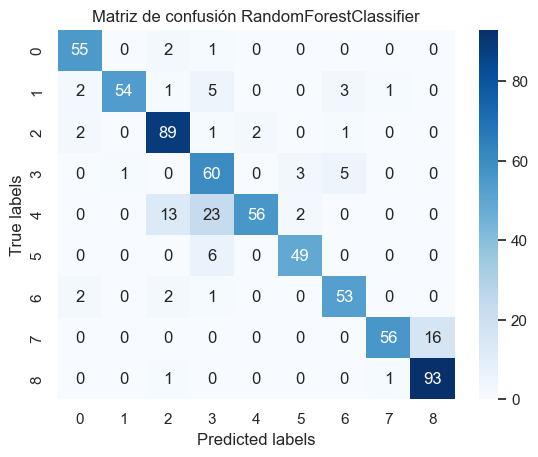

In [9]:
# ------- Matriz de confusión --------
plot_confusion_matrix(rf, test_X, test_y)

### 2.3 Hipermetrización

In [10]:
#------------- Mallas de Parametros ---------------
param_grid_knn = {
    'n_neighbors': [6, 7, 8],
    'weights': ('uniform', 'distance'),
    'leaf_size': (3, 4, 5, 6, 8),
    'p': (1,2),
    'metric': ('minkowski', 'chebyshev')
}

param_grid_dtree = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 40, 50, 60],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 2, 5, 7],
    'max_features': [None, 'sqrt', 'log2']
}

param_grid_nb = {'var_smoothing': np.logspace(0, -8, num=100)}


param_grid_svm = {
    'C': [0.1, 0.2, 0.3],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3],
    'coef0': [0.0, 0.1, 0.2]
}

param_grid_rf = {
    'n_estimators': [300, 400, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 50, 60],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 5, 6],
}


Modelo: KNeighborsClassifier
Mejores parámetros:  {'leaf_size': 3, 'metric': 'minkowski', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
Mejor resultado:  0.7570011733002088


<Figure size 600x400 with 0 Axes>

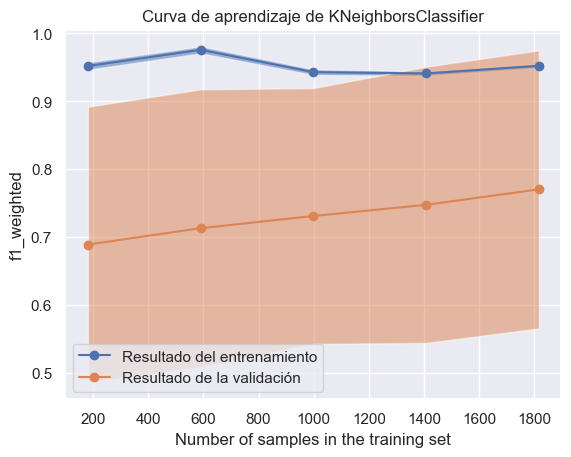


Modelo: DecisionTreeClassifier
Mejores parámetros:  {'criterion': 'log_loss', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 7, 'min_samples_split': 2, 'splitter': 'random'}
Mejor resultado:  0.8255248788780715


<Figure size 600x400 with 0 Axes>

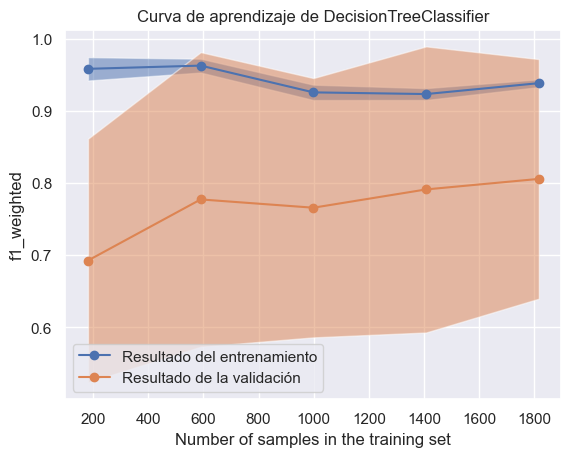


Modelo: GaussianNB
Mejores parámetros:  {'var_smoothing': 3.853528593710527e-06}
Mejor resultado:  0.6525840380428016


<Figure size 600x400 with 0 Axes>

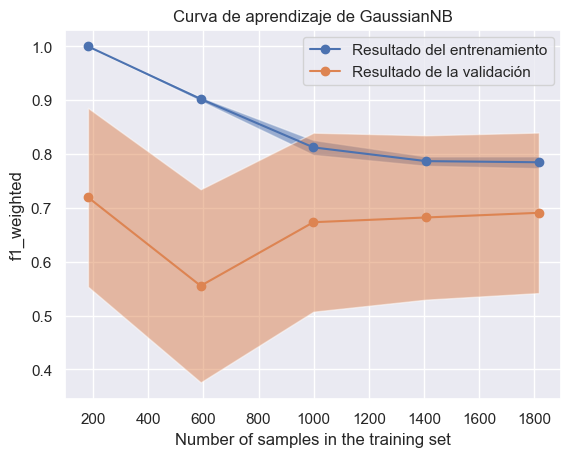


Modelo: SVC
Mejores parámetros:  {'C': 0.1, 'coef0': 0.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Mejor resultado:  0.8222667894514814


<Figure size 600x400 with 0 Axes>

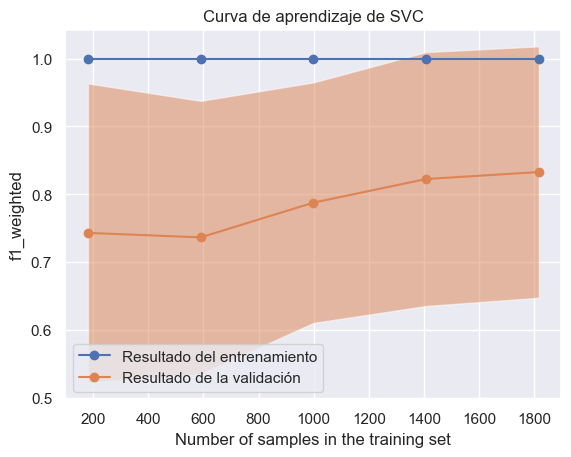


Modelo: RandomForestClassifier
Mejores parámetros:  {'n_estimators': 500, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 60}
Mejor resultado:  0.8623384551391616


<Figure size 600x400 with 0 Axes>

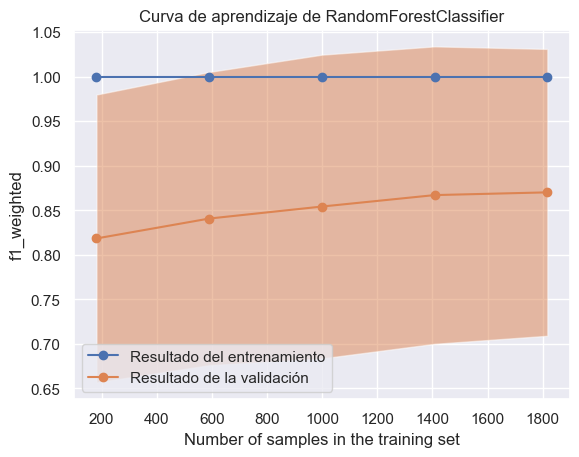

In [11]:
# ----- Aplicar hiperparametrización ---------------

# cv con LeaveOneGroupOut
logo = LeaveOneGroupOut()
subject_ids = train_X['SubjectID'] # para los grupos

# crear los modelos con GridSearchCV
gs_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn,cv=logo,
                      scoring='f1_weighted', n_jobs=-1)
gs_dtree = GridSearchCV(DecisionTreeClassifier(), param_grid_dtree, cv=logo,
                        scoring='f1_weighted', n_jobs=-1)
gs_nb = GridSearchCV(GaussianNB(), param_grid_nb, cv=logo,
                     scoring='f1_weighted', n_jobs=-1)
gs_svm = GridSearchCV(SVC(), param_grid_svm, cv=logo,
                      scoring='f1_weighted', n_jobs=-1)
gs_rf = RandomizedSearchCV(RandomForestClassifier(), param_grid_rf, cv=logo,
                           scoring='f1_weighted', n_jobs=-1)

modelos = [gs_knn, gs_dtree, gs_nb, gs_svm, gs_rf]

best_models = []
for modelo in modelos:
    # entrenar
    modelo.fit(train_X, train_y, groups=subject_ids)
    best_modelo = modelo.best_estimator_
    # imprimir resultado
    print(f"\nModelo: {modelo.estimator.__class__.__name__}") 
    print("Mejores parámetros: ", modelo.best_params_)
    print("Mejor resultado: ", modelo.best_score_)
    best_models.append(best_modelo)
    # curvas de apendizaje
    plt.figure(figsize=(6,4))
    LearningCurveDisplay.from_estimator(best_modelo, 
                                        X=train_X,
                                        y=train_y,
                                        groups=subject_ids,
                                        cv=logo,
                                        score_type="both",
                                        n_jobs=4,
                                        line_kw={"marker": "o"},
                                        std_display_style="fill_between",
                                        score_name="f1_weighted"
                                    )
        
    plt.legend(["Resultado del entrenamiento", "Resultado de la validación"])
    plt.title(f"Curva de aprendizaje de {modelo.estimator.__class__.__name__}")
    plt.show()

In [12]:
# -------- Evaluación de los modelos --------
test_models(best_models, test_X, test_y, test_result, 'Hiperparametrización (H)')


Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.76      0.93      0.84        58
           1       0.81      0.83      0.82        66
           2       0.63      0.65      0.64        95
           3       0.71      0.75      0.73        69
           4       0.83      0.46      0.59        94
           5       0.61      0.69      0.65        55
           6       0.94      0.86      0.90        58
           7       0.66      0.90      0.76        72
           8       0.74      0.67      0.71        95

    accuracy                           0.73       662
   macro avg       0.74      0.75      0.74       662
weighted avg       0.74      0.73      0.72       662


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.67      0.83      0.74        58
           1       0.73      0.88      0.80        66
           2       0.62      0.63      0.63        95
           3    

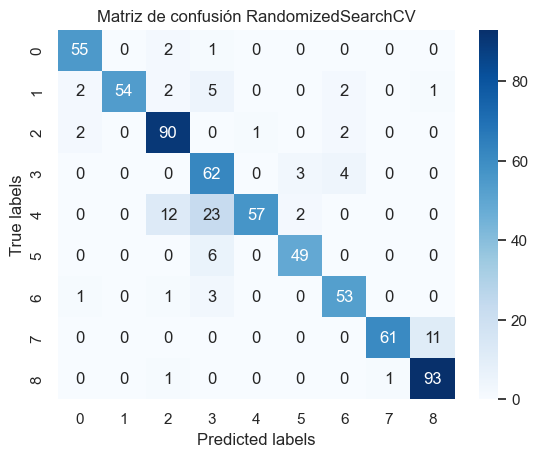

In [13]:
# --------- Matriz de confusión de RF ---------
plot_confusion_matrix(gs_rf, test_X, test_y)

### 2.4 Selección de variables

**2.4.1 SelectKBest**

Hay que tener en cunata que la columna *SubjectID* debe de estar en dataframe final para poder hacer los gurpos al realizar la validación cruzada con *LeaveOneGroupOut()*

In [14]:
subject_id = train_X['SubjectID']

# Definimos feature Selection K=50 (selecciona entonces las 50 variables que considere mas importantes)
feature_selection = SelectKBest(k=50)#, score_func=mutual_info_classif)

# Fit Feature Selection (entrena y hace una tranformada)
selected_features = feature_selection.fit_transform(train_X.drop(columns=['SubjectID']), train_y)

# Selecionamos las características mas relevantes para nuestro problema
selected = feature_selection.get_support(indices=True)

print(train_X.columns[selected])

# Reduce train_X to the selected features with .transform(X)
# esto elimina las variales que no nos intersan.

X_fs = pd.DataFrame(selected_features,
                 columns=train_X.drop(columns=['SubjectID']).columns[selected])

X_fs['SubjectID'] = subject_id.values


Index(['Duration', 'ElbowAngleRight_standardDeviation',
       'ElbowAngleLeft_standardDeviation',
       'ShoulderAngleLeft_standardDeviation',
       'WristAngleLeft_standardDeviation', 'RightArmAngle_standardDeviation',
       'LeftArmAngle_standardDeviation', 'KneeAngleRight_standardDeviation',
       'HipAngleRight_standardDeviation',
       'ArmsTogetherAngle_standardDeviation',
       'AnkleAngleLeft_standardDeviation', 'ElbowAngleRight_Maximum',
       'ElbowAngleLeft_Maximum', 'ShoulderAngleLeft_Maximum',
       'ElbowAngleLeft_Minimum', 'ShoulderAngleLeft_Minimum',
       'WristAngleLeft_Minimum', 'RightArmAngle_Minimum',
       'HipAngleRight_Minimum', 'ElbowAngleLeft_Mean',
       'ShoulderAngleLeft_Mean', 'WristAngleLeft_Mean', 'RightArmAngle_Mean',
       'HipAngleRight_Mean', 'AnkleAngleLeft_Mean', 'ElbowAngleRight_Range',
       'ElbowAngleLeft_Range', 'ShoulderAngleLeft_Range',
       'WristAngleLeft_Range', 'RightArmAngle_Range', 'LeftArmAngle_Range',
       'HipAngle

In [15]:
# ----- Entrenar con variables seleccionadas ----------
knn_fs = KNeighborsClassifier() # K-Neighbors classifier
dtree_fs = DecisionTreeClassifier() # Decision tree
nb_fs = GaussianNB() # Naive Bayes
svm_fs = SVC() # Suport Vector Machine
rf_fs = RandomForestClassifier()  # Random Forest

models_fs = [knn_fs, dtree_fs, nb_fs, svm_fs, rf_fs]

logo = LeaveOneGroupOut()

for modelo in models_fs:
        print(f"\nModelo: {modelo.__class__.__name__}")
        modelo.fit(X_fs, train_y)
        scores = cross_val_score(modelo, X_fs, train_y, groups=X_fs['SubjectID'], 
                                 scoring='f1_weighted', cv=logo)
        print("%0.2f F1 score con una derivación estandar de %0.2f" % (scores.mean(), scores.std()))


Modelo: KNeighborsClassifier
0.70 F1 score con una derivación estandar de 0.19

Modelo: DecisionTreeClassifier
0.82 F1 score con una derivación estandar de 0.18

Modelo: GaussianNB
0.66 F1 score con una derivación estandar de 0.14

Modelo: SVC
0.60 F1 score con una derivación estandar de 0.15

Modelo: RandomForestClassifier
0.86 F1 score con una derivación estandar de 0.17


In [16]:
# ------ Transformar el conjunto de test y evaluación -----------
test_subject_id = test_X['SubjectID']

selected_features_test = feature_selection.transform(test_X.drop(columns=['SubjectID']))

X_fs_test = pd.DataFrame(selected_features_test,
                         columns=test_X.drop(columns=['SubjectID']).columns[selected])

X_fs_test['SubjectID'] = test_subject_id.values

test_models(models_fs, X_fs_test, test_y, test_result, 'Selección de variables (FS)')


Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.74      0.97      0.84        58
           1       0.82      0.88      0.85        66
           2       0.67      0.80      0.73        95
           3       0.65      0.64      0.64        69
           4       0.49      0.39      0.44        94
           5       0.55      0.73      0.62        55
           6       0.96      0.86      0.91        58
           7       0.82      0.75      0.78        72
           8       0.79      0.56      0.65        95

    accuracy                           0.71       662
   macro avg       0.72      0.73      0.72       662
weighted avg       0.71      0.71      0.70       662


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.68      0.95      0.79        58
           1       0.92      0.83      0.87        66
           2       0.77      0.75      0.76        95
           3    

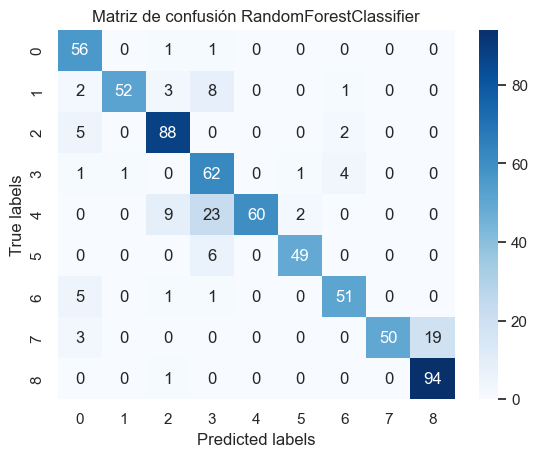

In [18]:
# --------- Matriz de confusión -------------
plot_confusion_matrix(rf_fs, X_fs_test, test_y,)

**2.4.2 Modelos con hiperparametrización y selección de variables**

Entrenar los modelos a los cuales se la ha realizado el ajuste de hiperparámetros con las variables seleccionadas anteriormente

In [19]:
# Entrenar los modelos
for modelo in best_models:
    modelo.fit(X_fs, train_y)

# Evaluación
test_models(best_models, X_fs_test, test_y, test_result, 'H + Fs')


Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.77      0.98      0.86        58
           1       0.81      0.88      0.84        66
           2       0.72      0.84      0.78        95
           3       0.74      0.74      0.74        69
           4       0.69      0.47      0.56        94
           5       0.57      0.75      0.65        55
           6       0.96      0.86      0.91        58
           7       0.88      0.85      0.87        72
           8       0.90      0.75      0.82        95

    accuracy                           0.77       662
   macro avg       0.78      0.79      0.78       662
weighted avg       0.78      0.77      0.77       662


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        58
           1       0.98      0.65      0.78        66
           2       0.70      0.85      0.77        95
           3    

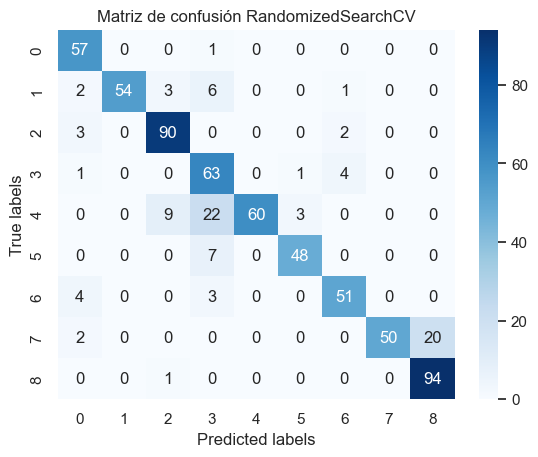

In [20]:
# ------- Matriz de confusión de RF -------------------
plot_confusion_matrix(gs_rf, X_fs_test, test_y)

**2.4.3 Recursive feature elimination**

Selección de varaibles con RFECV

In [21]:
# Modelos a los que se puede aplicar RFECV
dtree_rfe = DecisionTreeClassifier() # Decision tree
rf_rfe = RandomForestClassifier(n_estimators = 5)  # Random Forest

models_with_coef = [dtree_rfe, rf_rfe]


Modelo: DecisionTreeClassifier
Número óptimo de características: 12
['RightArmAngle_standardDeviation' 'ElbowAngleRight_Maximum'
 'ShoulderAngleLeft_Maximum' 'ShoulderAngleRight_Maximum'
 'HipAngleLeft_Maximum' 'RightArmAngle_Mean' 'HipAngleRight_Mean'
 'LeftArmAngle_Range' 'KneeAngleLeft_Range' 'KneeAngleRight_Range'
 'ElbowAngleLeft_Variance' 'HipAngleLeft_CoV']
0.7885196374622356


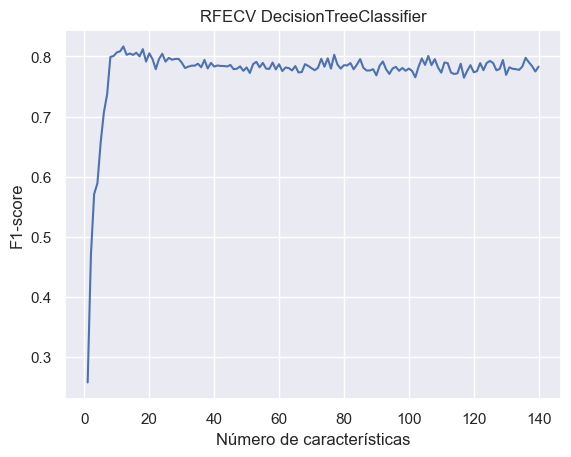


Modelo: RandomForestClassifier
Número óptimo de características: 47
['ElbowAngleRight_standardDeviation' 'ElbowAngleLeft_standardDeviation'
 'ShoulderAngleRight_standardDeviation'
 'AnkleAngleRight_standardDeviation' 'LeftArmAngle_standardDeviation'
 'KneeAngleRight_standardDeviation' 'HipAngleLeft_standardDeviation'
 'ElbowAngleRight_Maximum' 'ElbowAngleLeft_Maximum'
 'ShoulderAngleLeft_Maximum' 'ShoulderAngleRight_Maximum'
 'LeftArmAngle_Maximum' 'HipAngleRight_Maximum'
 'ShoulderAngleLeft_Minimum' 'RightArmAngle_Minimum'
 'LeftArmAngle_Minimum' 'ArmsTogetherAngle_Minimum' 'ElbowAngleRight_Mean'
 'ElbowAngleLeft_Mean' 'ShoulderAngleLeft_Mean' 'RightArmAngle_Mean'
 'LeftArmAngle_Mean' 'ElbowAngleRight_Range' 'ElbowAngleLeft_Range'
 'ShoulderAngleLeft_Range' 'ShoulderAngleRight_Range'
 'RightArmAngle_Range' 'LeftArmAngle_Range' 'KneeAngleLeft_Range'
 'WristAngleRight_Range' 'KneeAngleRight_Range' 'HipAngleLeft_Range'
 'ElbowAngleRight_Variance' 'ElbowAngleLeft_Variance'
 'ShoulderAngl

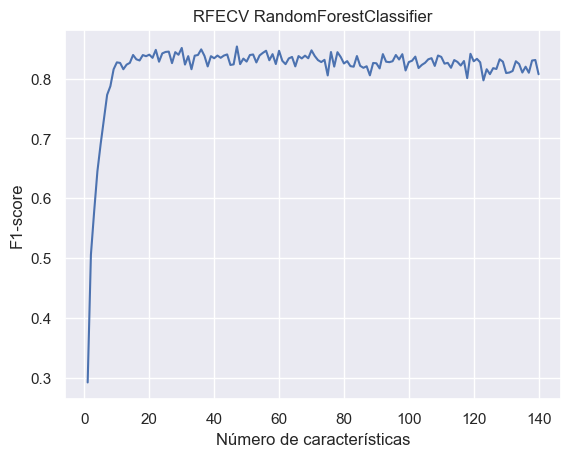

In [22]:
# ------- Aplicar RFECV ----------
for model in models_with_coef:
    rfecv = RFECV(
            estimator=model,
        scoring="f1_weighted",
        cv = LeaveOneGroupOut(),
        n_jobs=-1 
    )
    # entrenar
    rfecv.fit(train_X, train_y, groups=train_X['SubjectID'])
    # mostrar resultados
    print(f"\nModelo: {rfecv.estimator.__class__.__name__}") 
    print(f"Número óptimo de características: {rfecv.n_features_}")
    selected = rfecv.get_feature_names_out()
    print(selected)
    print(rfecv.score(test_X, test_y))
    # mostrar gráfica
    cv_results = pd.DataFrame(rfecv.cv_results_)
    plt.title(f"RFECV {rfecv.estimator.__class__.__name__}")
    plt.xlabel("Número de características")
    plt.ylabel("F1-score")
    plt.plot(range(1, len(cv_results['mean_test_score']) + 1),
             cv_results['mean_test_score'])
    plt.show()


****

## 3. Evaluación de los modelos

In [23]:
#-------- Dataframe con los f1-scores ------
test_result

,Clasificadores,Modelos,Hiperparametrización (H),Selección de variables (FS),H + Fs
0,K-Neighbors,0.688613,0.724436,0.701863,0.771565
1,Decision tree,0.743130,0.732850,0.777595,0.758859
2,Naive Bayes,0.678895,0.674416,0.734144,0.736108
3,Suport Vector Machine,0.717582,0.785543,0.583022,0.824445
4,Random Forest,0.852412,0.866839,0.848831,0.856091


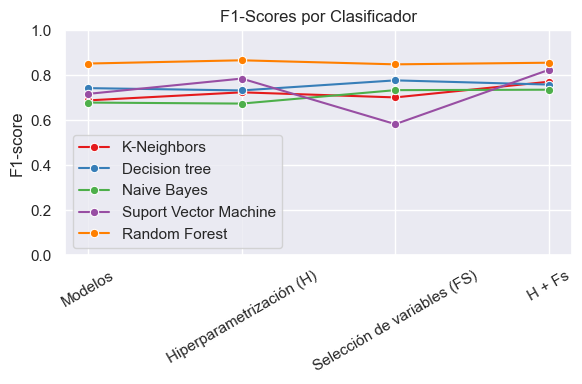

In [24]:
# ------- Gráfica comparativa -------
x_labels = ['Modelos', 'Hiperparametrización (H)', 'Selección de variables (FS)', 'H + Fs']
df_melted = pd.melt(test_result, id_vars=['Clasificadores'], value_vars=x_labels,
                    var_name='score_type', value_name='score')

plt.figure(figsize=(6, 4))
ax = sns.lineplot(x='score_type', y='score', hue='Clasificadores',
                  data=df_melted, marker='o', palette='Set1')

ax.set(xlabel=None)
plt.ylabel('F1-score')
plt.title('F1-Scores por Clasificador')
plt.ylim(0,1)
plt.legend(loc='lower left')

plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
plt.show()